# Introduction <a name="introduction"></a>

The goal of this project is to answer the question: "<u>to what extent can an NBA player's gameplay statistics be used to determine their position?</u>" We treat this as a classification problem, using the K-Nearest-Neighbor algorithm to predict position using past gameplay statistics. This notebook is our final iteration in a series of attempts to predict the position of NBA players. We describe our earlier work carefully and include links to it at the end of this notebook, but we only include the code for "this iteration". Below is a figure listing each position and depicting their intended locations.


<img align="center"
     src="https://upload.wikimedia.org/wikipedia/commons/a/ac/Basketball_Positions.png" width="400" height="400"
     alt="imageinfo" 
     style=""
     id="figure_1"/>

*Figure 1 : Basketball Positions*



This project is inspired by the ambiguity of basketball positions, based on how the game is played in U.S. National-Basketball-Association (NBA) regulation basketball. In NBA Basketball, there are no players consistently on offense or defense, the court size is small compared to many other "invasion" sports, and the gameplay is fast. Although players have officially stated positions, a first, second, or one-hundredth time viewer would be forgiven if skeptical about how closely players stick to their assigned positions. *But*, spectators are likely able to easily realize different groups of positions. The taller, slower players who spend most of their time near the net play very differently from the shorter, agile players who generally stay outside the 3-point line. The question of which positions can be differentiated from one another will be an enduring theme of this notebook. 





**Literature Review**

From research done in 2001, body height has been examined to be a variable that has the greatest effect on basketball players’ positions (Dezman et al., 2001). Another study has evaluated that the ability to sustain high-intensity intermittent effort and strength or power characteristics can discriminate players’ positions, i.e. different positions may require different types of characteristics (Ferioli et al., 2018). Thus, we conclude that each of these positions requires different talents and physical traits for success at the professional level. We then hypothesize, based on relevant research, that these traits will predict the position of a player, and that they will manifest in the data as differing gameplay statistics. 

**The Data**

We are working with two separate datasets that both originally come from <a href="basketball-reference.com">basketball-reference.com</a> We initially found a more convenient form of these two datasets (as a .csv file) that is available for download from Kaggle (https://www.kaggle.com/datasets/drgilermo/nba-players-stats). We store the data in a Git Repository for easy access from this notebook.

The first dataset contains gameplay statistics for all NBA players from 1950 to the present. Gameplay statistics include in-game actions like blocks, steals, the number of three-pointer-attempts, and so on. Many of these statistics are derived from other statistics, and are presented in the form of ratios or percentages. We will not be using any derived statistics. 

The second dataset contains height, weight, and other information for all NBA players from 1950 to the present.

# Methods

## Cleaning the Data

Before starting, we ensure the appropriate libraries are installed, and a seed is set in order to ensure the reproducibility of this notebook. 

In [1]:
library(tidyverse)
library(tidymodels)
library(viridis)

set.seed(1234)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   0.3.5 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.1     ✔ rsample      1.1.0
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.3     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.3     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() ma

We start by loading the season stats and outputting a snapshot of what they look like:

In [2]:
urlfile_1 <- "https://raw.githubusercontent.com/cass12345/ddssccii/main/Seasons_Stats.csv"
raw_season_stats <- read_csv(url(urlfile_1), show_col_types = FALSE)

raw_season_stats |> 
    select(2:19) |>   # Select the first 18 columns, after the id
    drop_na() |>      # Drop rows with NA observatinos
    head()            # Show just the first 5 rows

New names:
• `` -> `...1`


Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%
<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1980,Tiny Archibald*,PG,31,BOS,80,80,2864,15.3,0.574,0.023,0.548,2.3,5.3,3.8,30.2,1.7,0.2
1980,Larry Bird*,PF,23,BOS,82,82,2955,20.5,0.538,0.098,0.246,8.3,23.6,16.0,18.5,2.3,1.0
1980,M.L. Carr,SF,29,BOS,82,7,1994,14.6,0.526,0.054,0.316,6.0,12.3,9.2,10.7,2.8,1.0
1980,Don Chaney,SG,33,BOS,60,0,523,7.8,0.402,0.032,0.222,6.7,8.8,7.8,9.3,2.8,1.2
1980,Dave Cowens*,C,31,BOS,66,55,2159,14.8,0.477,0.013,0.131,6.6,20.7,13.8,13.4,1.5,1.6
1980,Eric Fernsten,PF,26,BOS,56,0,431,14.4,0.497,0.000,0.340,10.5,14.3,12.4,8.7,1.8,1.6


We filter the raw season stats to only include the 5 positions common today, shown in [Figure 1](#figure_1), and to remove rows with no minutes played or outside the the season range: [2000, 2015]. 

In [3]:
filtered_stats <- raw_season_stats |>
    filter(MP != 0) |>
    filter(Pos %in% c("PF","PG","SF","SG","C")) |>
    filter(Year >= 2000 & Year <= 2015)

From the filtered data, we select 7 non-derived , gameplay statistics (no ratios, percentages, etc.) Throughout this notebook these statistics will be referred to by their abbreviations given below.

| Abbreviation      | Full | Description (# = number of times a player ...) | 
| ----------- | ----------- | ----------- 
| BLK         | Blocks      | # blocks the opposing team from scoring
| AST         | Assists     | # passes to another player on their team who scores
| STL         | Steals      | # steals the ball from the opposing team
| PF       | Personal Fouls | # fouls a member of the opposing team
| TRB      | Total Rebounds | # gains possession of the ball after an attempted basket (from their team or opposing)
| MP       | Minutes Played | # plays for a whole minute
| 3PA     | 3 Point Attempts| # shoots from outside the 3 - point line (far from the basket)


In [4]:
selected_stats <- filtered_stats |>
    select(Player, Pos, BLK, AST, TRB, STL, MP, "3PA", PF)

We rename several columns and mutate the position column to be a factor (it will be the class we are predicting.)

In [5]:
renamed_stats <- selected_stats |>
    rename(name = Player) |>
    rename(three_PA = "3PA") |>
    mutate(pos = as_factor(Pos), 
           .keep = "unused", 
           .after = 1)

renamed_stats |> head()

name,pos,BLK,AST,TRB,STL,MP,three_PA,PF
<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Tariq Abdul-Wahad,SG,28,98,291,59,1578,23,147
Tariq Abdul-Wahad,SG,16,72,239,53,1205,21,116
Tariq Abdul-Wahad,SG,12,26,52,6,373,2,31
Shareef Abdur-Rahim,SF,87,271,825,89,3223,96,244
Cory Alexander,PG,2,58,42,24,329,35,39
Ray Allen,SG,19,308,359,110,3070,407,187


We combine rows by summarizing the cumulative statistics for each player in each positon. If a player played in multiple  positions between 2000 and 2015, there will be one row for each of the positions they've played. 

In [6]:
cumulative_stats <- renamed_stats |>
    group_by(name, pos) |>
    summarize(across(.cols  = c(BLK, AST, TRB, STL, MP, three_PA, PF), 
                     .fns   = list(sum=sum),
                     .names = "{.col}"),
              .groups = "keep")

We divide each player's cumulative stats by the number of minutes each player has played in their position, between 2000 and 2015.

In [7]:
per_m_stats <- cumulative_stats |>
    mutate(across(.cols  = c(BLK, AST, TRB, STL, three_PA, PF),
                  .fns   = list(function(.){return(./MP)}),
                  .names = "{.col}_per_MP"),
           .keep = "unused")

per_m_stats |> head()

name,pos,BLK_per_MP,AST_per_MP,TRB_per_MP,STL_per_MP,three_PA_per_MP,PF_per_MP
<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A.C. Green,PF,0.007784431,0.03562874,0.23922156,0.02485030,0.002994012,0.07365269
A.J. Bramlett,C,0.000000000,0.00000000,0.36065574,0.01639344,0.000000000,0.21311475
A.J. Guyton,PG,0.009630819,0.11797753,0.06420546,0.01605136,0.154895666,0.04654896
A.J. Price,SG,0.000000000,0.13131313,0.10101010,0.01010101,0.222222222,0.05050505
A.J. Price,PG,0.002166586,0.14443909,0.09605200,0.03153587,0.174530573,0.05946076
Aaron Brooks,PG,0.006230943,0.14450484,0.07888108,0.02744266,0.165186265,0.08743206


Now we load the height and weight data.

In [8]:
urlfile_2 <- "https://raw.githubusercontent.com/cass12345/ddssccii/main/player_data.csv"
raw_player_data <- read_csv(url(urlfile_2), show_col_types = FALSE)

raw_player_data |> head()

name,year_start,year_end,position,height,weight,birth_date,college
<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>
Alaa Abdelnaby,1991,1995,F-C,6-10,240,"June 24, 1968",Duke University
Zaid Abdul-Aziz,1969,1978,C-F,6-9,235,"April 7, 1946",Iowa State University
Kareem Abdul-Jabbar,1970,1989,C,7-2,225,"April 16, 1947","University of California, Los Angeles"
Mahmoud Abdul-Rauf,1991,2001,G,6-1,162,"March 9, 1969",Louisiana State University
Tariq Abdul-Wahad,1998,2003,F,6-6,223,"November 3, 1974",San Jose State University
Shareef Abdur-Rahim,1997,2008,F,6-9,225,"December 11, 1976",University of California


Below, we convert height to a numerical type via a little wrangling:

In [9]:
# 5 : wrangling the height/weight data

player_ht_wt <- raw_player_data |>
    select(name, height, weight) |>
    separate(col  = height,
             into = c("feet","inches"),
             sep  = "-",
             convert = TRUE) |>
    mutate(height = feet * 12  + inches) |>
    select(name, weight, height)

player_ht_wt |> head()

name,weight,height
<chr>,<dbl>,<dbl>
Alaa Abdelnaby,240,82
Zaid Abdul-Aziz,235,81
Kareem Abdul-Jabbar,225,86
Mahmoud Abdul-Rauf,162,73
Tariq Abdul-Wahad,223,78
Shareef Abdur-Rahim,225,81


And finally, we are ready to merge our datasets!

In [10]:
# 6 : merging the season stats and height/weight data

merged_data <- merge(x = per_m_stats, y = player_ht_wt, by.x = "name", by.y = "name") |>
    drop_na()
head(merged_data)

,name,pos,BLK_per_MP,AST_per_MP,TRB_per_MP,STL_per_MP,three_PA_per_MP,PF_per_MP,weight,height
,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,A.C. Green,PF,0.007784431,0.03562874,0.23922156,0.02485030,0.002994012,0.07365269,220,81
2,A.J. Bramlett,C,0.000000000,0.00000000,0.36065574,0.01639344,0.000000000,0.21311475,227,82
3,A.J. Guyton,PG,0.009630819,0.11797753,0.06420546,0.01605136,0.154895666,0.04654896,180,73
4,A.J. Price,SG,0.000000000,0.13131313,0.10101010,0.01010101,0.222222222,0.05050505,181,74
5,A.J. Price,PG,0.002166586,0.14443909,0.09605200,0.03153587,0.174530573,0.05946076,181,74
6,Aaron Brooks,PG,0.006230943,0.14450484,0.07888108,0.02744266,0.165186265,0.08743206,161,72


After having merged our datasets, we reserve 25% of the data to be set aside. We will use this to determine if our model is picking up on the underlying patterns we are interested in, or just fitting our training data.

In [11]:
data_split <- initial_split(merged_data, prop = 0.75, strata = pos)
train_data <- training(data_split)
test_data <- testing(data_split)

<br><br><br>

## Exploratory Analysis

We will use several boxplots to visualize the difference in distributions between positions, so we define a boxplot function below to simplify our code later on. 

In [12]:
make_boxplot <- function(train_df) {
    boxplot <- train_df |>
        mutate(across(where(is.numeric), scale)) |>
        pivot_longer(3:10, names_to = "key", values_to = "value") |>
        filter(value < 5 & value > -5) |>
        ggplot(aes(x = value, fill = pos)) +
        geom_boxplot(position = "dodge", alpha = 1, varwidth = TRUE) +
        facet_wrap(~key, ncol = 2) +
        scale_fill_viridis(option="magma", discrete=TRUE) +
        theme(text = element_text(size = 18),
              axis.title.y=element_blank(),
              axis.text.y=element_blank(),
              axis.ticks.y=element_blank())
    return(boxplot)
}

Below we plot the distributions of each of our predictor variables using boxplots, after standardizing.

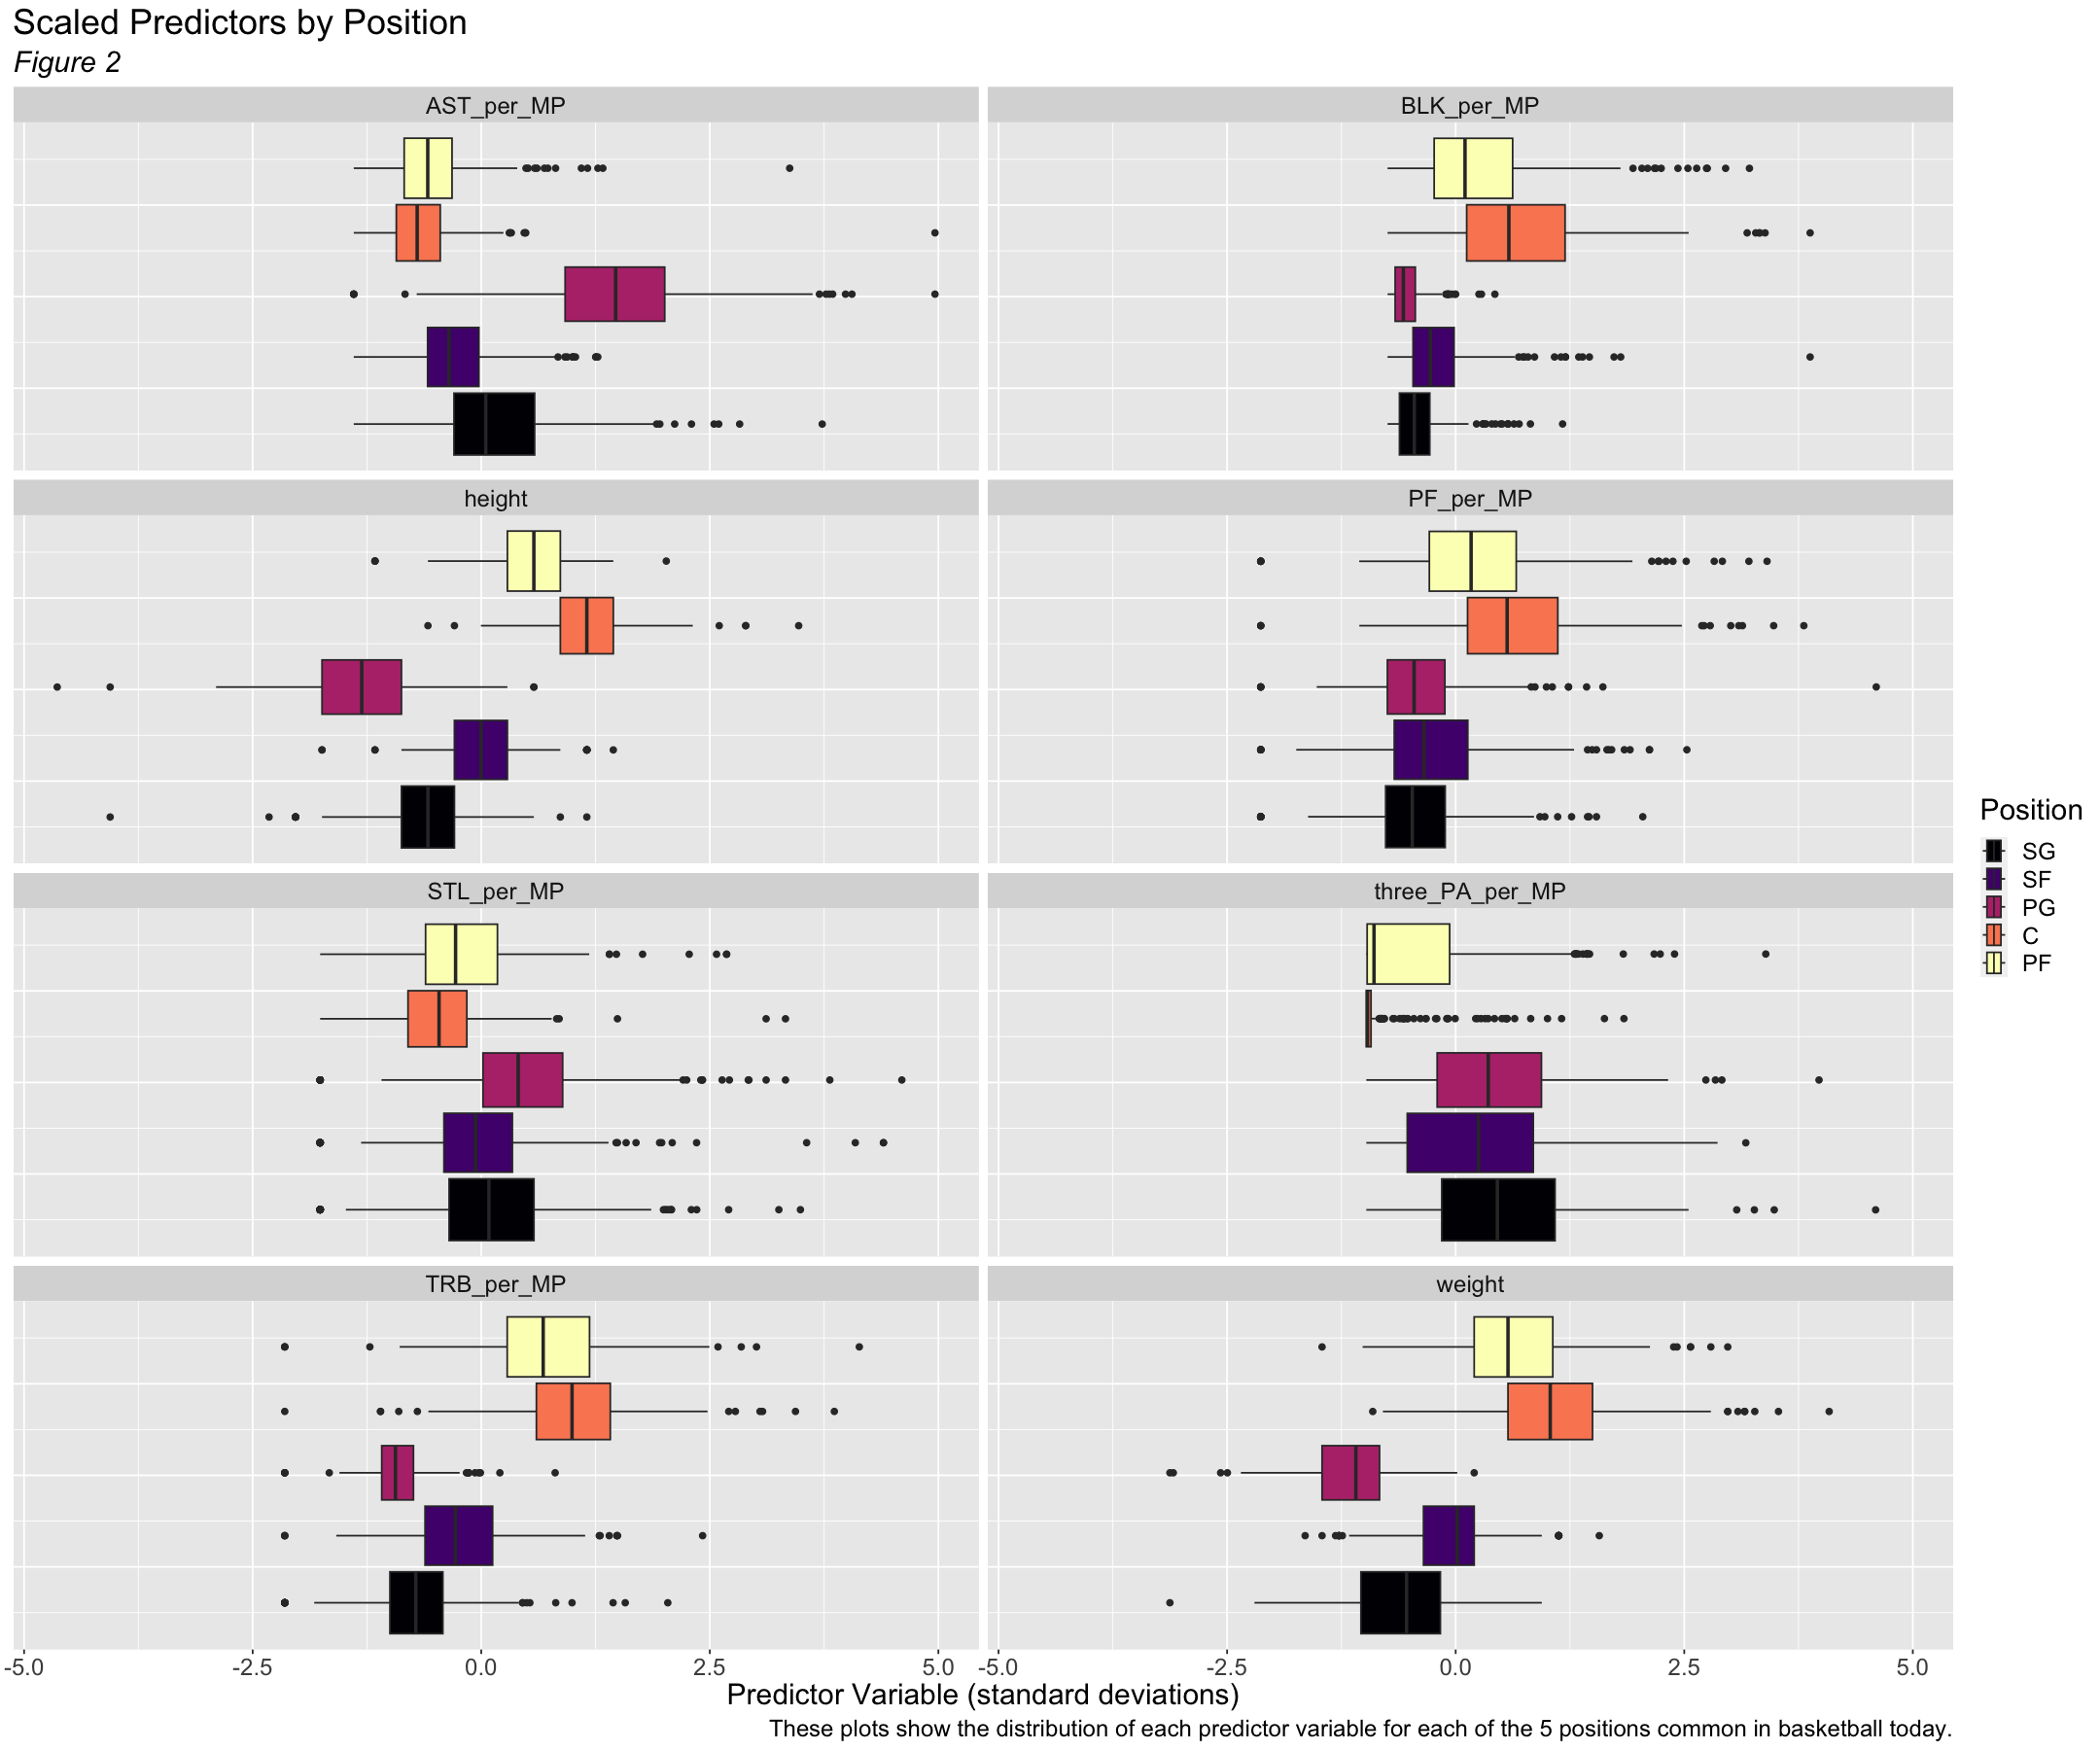

In [13]:
options(repr.plot.width = 18, repr.plot.height = 15, repr.plot.margin = 15)

train_data |>
    make_boxplot() +
    labs(x = "Predictor Variable (standard deviations)", 
         y = "Frequency (count)", 
         title="Scaled Predictors by Position", 
         fill = "Position",
         subtitle = "Figure 2",
         caption = "These plots show the distribution of each predictor variable for each of the 5 positions common in basketball today."
        ) +
    theme(plot.subtitle=element_text(size=18, face="italic", color="black"))

**A pattern revealed**

In most of the plots above, Centers and Power Forwards (henceforth "Forwards") have largely overlapping distributions, while Point Guards and Shooting Guards (henceforth "Guards") have largely overlapping distributions. However, the Small Forward distributions overlap with the Forwards for some variables, but with the Guards for others, and is frequently between the Forwards and Guards. For example, in the 3PA and TRB plots, the Small Forward IQR is much closer to the IQRs of the Guard positions. But, in the height and BLK plots, the Small Forward IQR is roughly between the Forwards and Guards.

To explore this pattern further, we compare the distributions for the Guards, Forwards including Small Forward, and Forwards excluding Small Forward:

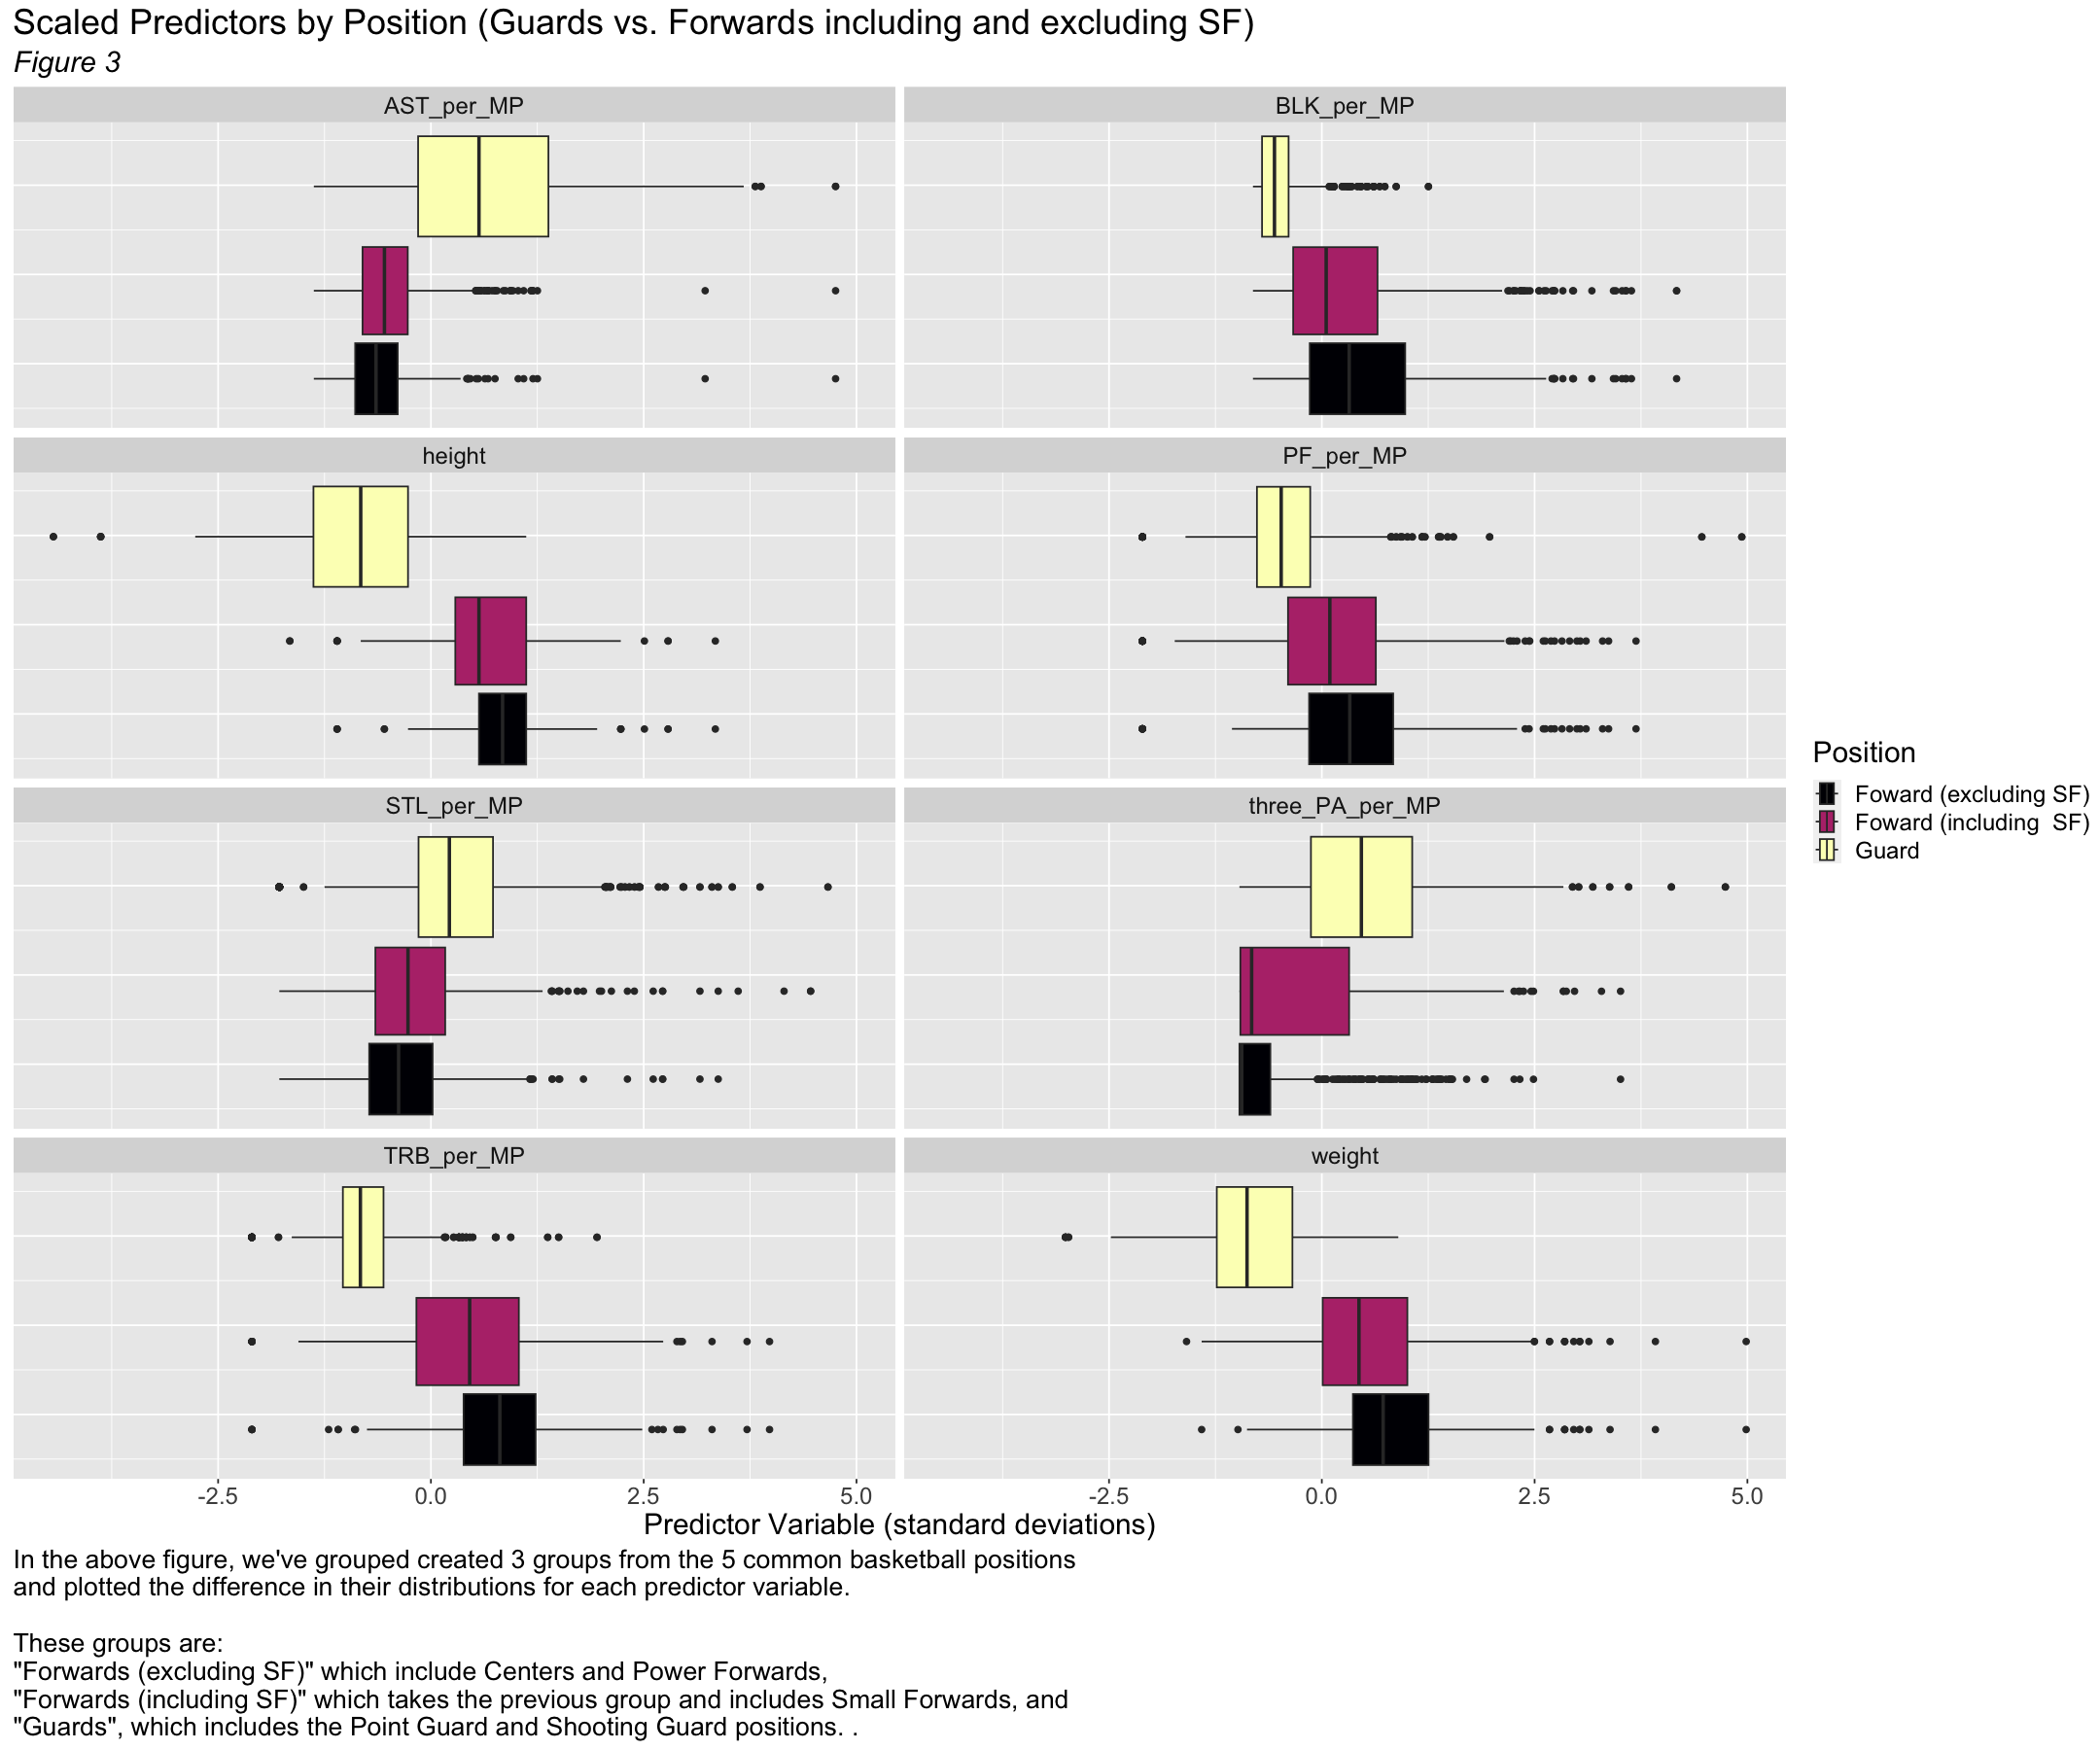

In [14]:
forward_with_sf <- train_data |>
    filter(pos != "SF") |>
    mutate(pos = ifelse(pos %in% c("C", "PF"), "Foward (excluding SF)", "Guard"))

forward_wo_sf <- train_data |>
    mutate(pos = ifelse(pos %in% c("C", "PF", "SF"), "Foward (including  SF)", "Guard"))

rbind(forward_with_sf, forward_wo_sf) |>
    make_boxplot() +
    labs(x = "Predictor Variable (standard deviations)", 
         y = "Frequency (count)", 
         title="Scaled Predictors by Position (Guards vs. Forwards including and excluding SF)", 
         fill = "Position",
         caption = "In the above figure, we've grouped created 3 groups from the 5 common basketball positions\nand plotted the difference in their distributions for each predictor variable. \n\nThese groups are: \n\"Forwards (excluding SF)\" which include Centers and Power Forwards, \n\"Forwards (including SF)\" which takes the previous group and includes Small Forwards, and \n\"Guards\", which includes the Point Guard and Shooting Guard positions. .", 
         subtitle = "Figure 3") +
    theme(plot.subtitle = element_text(size=18, face="italic", color="black"),
          plot.caption = element_text(size = 16, hjust = 0))

Considering the figure above, adding Small Forward to the Forward group, for every single variable, moves the Forward distribution towards the Guard distribution. 

Going forward, we will group Centers and Power Forwards together, Point Guards and Shooting Guards together, and remove Small Forwards from our analysis all together. We discuss this choice thoroughly in the [Discussion section](#discussion).

In [15]:
grouped_train_data <- train_data |>
    filter(pos != "SF") |>
    mutate(pos = ifelse(pos %in% c("C", "PF"), "Forward", "Guard")) |>
    mutate(pos = as_factor(pos))

grouped_test_data <- test_data |>
    filter(pos != "SF") |>
    mutate(pos = ifelse(pos %in% c("C", "PF"), "Forward", "Guard")) |>
    mutate(pos = as_factor(pos))

To conclude our exploratory data analysis, we give a tabular summary of the predictor columns for the forwards and guards:

In [16]:
grouped_train_data |> 
    filter(pos == "Forward") |> 
    select(!name & !pos) |>
    summary()

   BLK_per_MP        AST_per_MP        TRB_per_MP       STL_per_MP     
 Min.   :0.00000   Min.   :0.00000   Min.   :0.0000   Min.   :0.00000  
 1st Qu.:0.01676   1st Qu.:0.02641   1st Qu.:0.2044   1st Qu.:0.01781  
 Median :0.02842   Median :0.03973   Median :0.2395   Median :0.02364  
 Mean   :0.03337   Mean   :0.04249   Mean   :0.2409   Mean   :0.02482  
 3rd Qu.:0.04494   3rd Qu.:0.05360   3rd Qu.:0.2743   3rd Qu.:0.03046  
 Max.   :0.33333   Max.   :0.33333   Max.   :1.0000   Max.   :0.22222  
 three_PA_per_MP      PF_per_MP           weight          height     
 Min.   :0.000000   Min.   :0.00000   Min.   :180.0   Min.   :75.00  
 1st Qu.:0.000000   1st Qu.:0.09964   1st Qu.:230.0   1st Qu.:81.00  
 Median :0.001822   Median :0.12373   Median :240.0   Median :82.00  
 Mean   :0.024889   Mean   :0.12951   Mean   :242.8   Mean   :81.97  
 3rd Qu.:0.023895   3rd Qu.:0.15008   3rd Qu.:255.0   3rd Qu.:83.00  
 Max.   :0.294118   Max.   :0.53846   Max.   :360.0   Max.   :91.00  

In [17]:
grouped_train_data |> 
    filter(pos == "Guard") |> 
    select(!name & !pos) |>
    summary()

   BLK_per_MP         AST_per_MP        TRB_per_MP        STL_per_MP     
 Min.   :0.000000   Min.   :0.00000   Min.   :0.00000   Min.   :0.00000  
 1st Qu.:0.002681   1st Qu.:0.06663   1st Qu.:0.08788   1st Qu.:0.02759  
 Median :0.006350   Median :0.10578   Median :0.10476   Median :0.03373  
 Mean   :0.007689   Mean   :0.11141   Mean   :0.10951   Mean   :0.03508  
 3rd Qu.:0.010502   3rd Qu.:0.15000   3rd Qu.:0.12702   3rd Qu.:0.04256  
 Max.   :0.051775   Max.   :0.36842   Max.   :0.33333   Max.   :0.16667  
 three_PA_per_MP     PF_per_MP           weight          height     
 Min.   :0.00000   Min.   :0.00000   Min.   :135.0   Min.   :63.00  
 1st Qu.:0.05519   1st Qu.:0.06829   1st Qu.:185.0   1st Qu.:74.00  
 Median :0.09411   Median :0.08283   Median :195.0   Median :76.00  
 Mean   :0.09681   Mean   :0.08757   Mean   :197.1   Mean   :75.85  
 3rd Qu.:0.13328   3rd Qu.:0.10000   3rd Qu.:210.0   3rd Qu.:78.00  
 Max.   :0.37500   Max.   :0.66667   Max.   :245.0   Max.   :83.00  

The table above shows the difference in statistics for each predictor column (in this table, a row). We've multiplied the gameplay predictors by 100 for ease of reading.

## Building the Classification Model

We will use the K-Nearest-Neighbors (KNN) classification algorithm to train our classification model.

We start by creating a recipe to standardize our predictors. We standardize our predictors to make sure that each variable will have the same impact on the distance used in our KNN algorithm, to produce the most accurate model.

In [28]:
first_recipe <- recipe(pos ~ BLK_per_MP + AST_per_MP + TRB_per_MP + three_PA_per_MP + weight + height,
                  data = grouped_train_data) |>
    step_center(all_predictors()) |>
    step_scale(all_predictors())

We create a grid of k_values that are used to tune our model, and a cross validation object to find a better estimate of the accuracy of a particular k by training/testing it on different parts of the training data.

In [19]:
first_ks <- tibble(neighbors = seq(from = 1, to = 250, by = 1))

first_vfold1 <- vfold_cv(grouped_train_data, v = 5, strata = pos)

We build the KNN spec using a regular weight_func (basically meaning we don't change the influence of neighboring points based on their distance to the point we wish to predict, so long as they are among the K nearest.  

In [20]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

And finally, we put the above steps together in a workflow and fit our model:

In [21]:
first_fit <- workflow() |>
    add_recipe(first_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = first_vfold1, grid = first_ks) |>
    collect_metrics() |>
    filter(.metric == "accuracy")

We visualize the accuracy of the model vs. K (the number of neighbors)

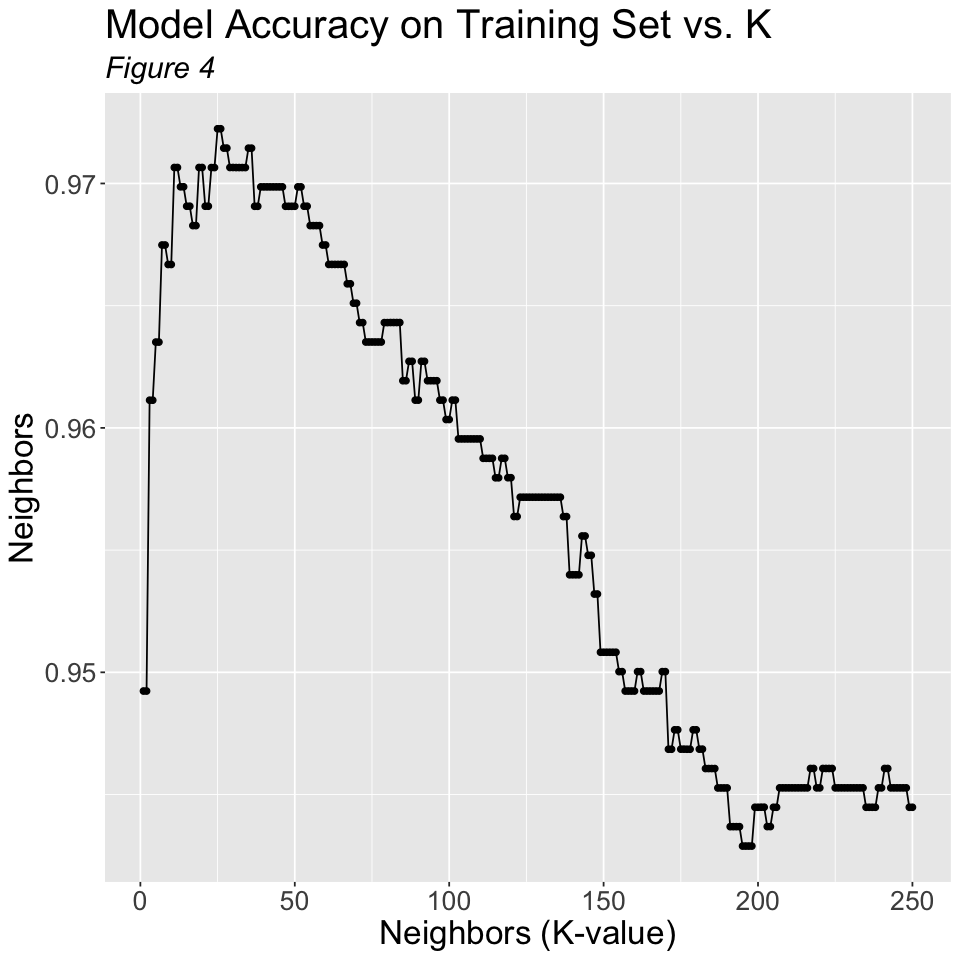

In [30]:
options(repr.plot.height = 8, repr.plot.width = 8)

first_fit |>
    ggplot(aes(x = neighbors, y = mean)) + 
    geom_point() +
    geom_line() +
    labs(x = "Neighbors (K-value)",
         title = "Model Accuracy on Training Set vs. K", 
         y = "Neighbors", 
         subtitle = "Figure 4") +
    theme(text = element_text(size = 20), 
          plot.subtitle = element_text(size=18, face="italic", color="black"))

Above we can see the K value with highest accuracy is around 20 - 30, where we see a peak in the plot. To get the exact value, we arrange the most accurate k values below.

In [23]:
first_fit |>
    arrange(by = desc(mean)) |>
    head()

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
25,accuracy,binary,0.9722379,5,0.004354186,Preprocessor1_Model025
26,accuracy,binary,0.9722379,5,0.004354186,Preprocessor1_Model026
27,accuracy,binary,0.9714474,5,0.003420231,Preprocessor1_Model027
28,accuracy,binary,0.9714474,5,0.003420231,Preprocessor1_Model028
35,accuracy,binary,0.9714443,5,0.002927817,Preprocessor1_Model035
36,accuracy,binary,0.9714443,5,0.002927817,Preprocessor1_Model036


Having found the best K value (25), we rebuild our KNN classification model to use 25 neighbors, fit it to the training data, and then test how it performs on the testing data.

In [31]:
best_k_model <- nearest_neighbor(weight_func = "rectangular", neighbors = 25) |>
    set_engine("kknn") |>
    set_mode("classification")

fitted_model <- workflow() |>
    add_recipe(first_recipe) |>
    add_model(best_k_model) |>
    fit(grouped_train_data)

predictions <- fitted_model |>
    predict(grouped_test_data) |>
    bind_cols(grouped_test_data)

metrics <- predictions |> 
    metrics(truth = pos, estimate = .pred_class) |> 
    filter(.metric == "accuracy")
 
metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.964455


There isn't a significant drop in accuracy when we test the model on data it wasn't trained on, signifying that it likely isn't  too overfit.

In [25]:
predictions |>
    conf_mat(truth = pos, estimate = .pred_class)

          Truth
Prediction Forward Guard
   Forward     202     6
   Guard         9   205

Above we show the confusion matrix of our model's predictions for the testing data. Our model was incorrect only 15 times (out of 422)

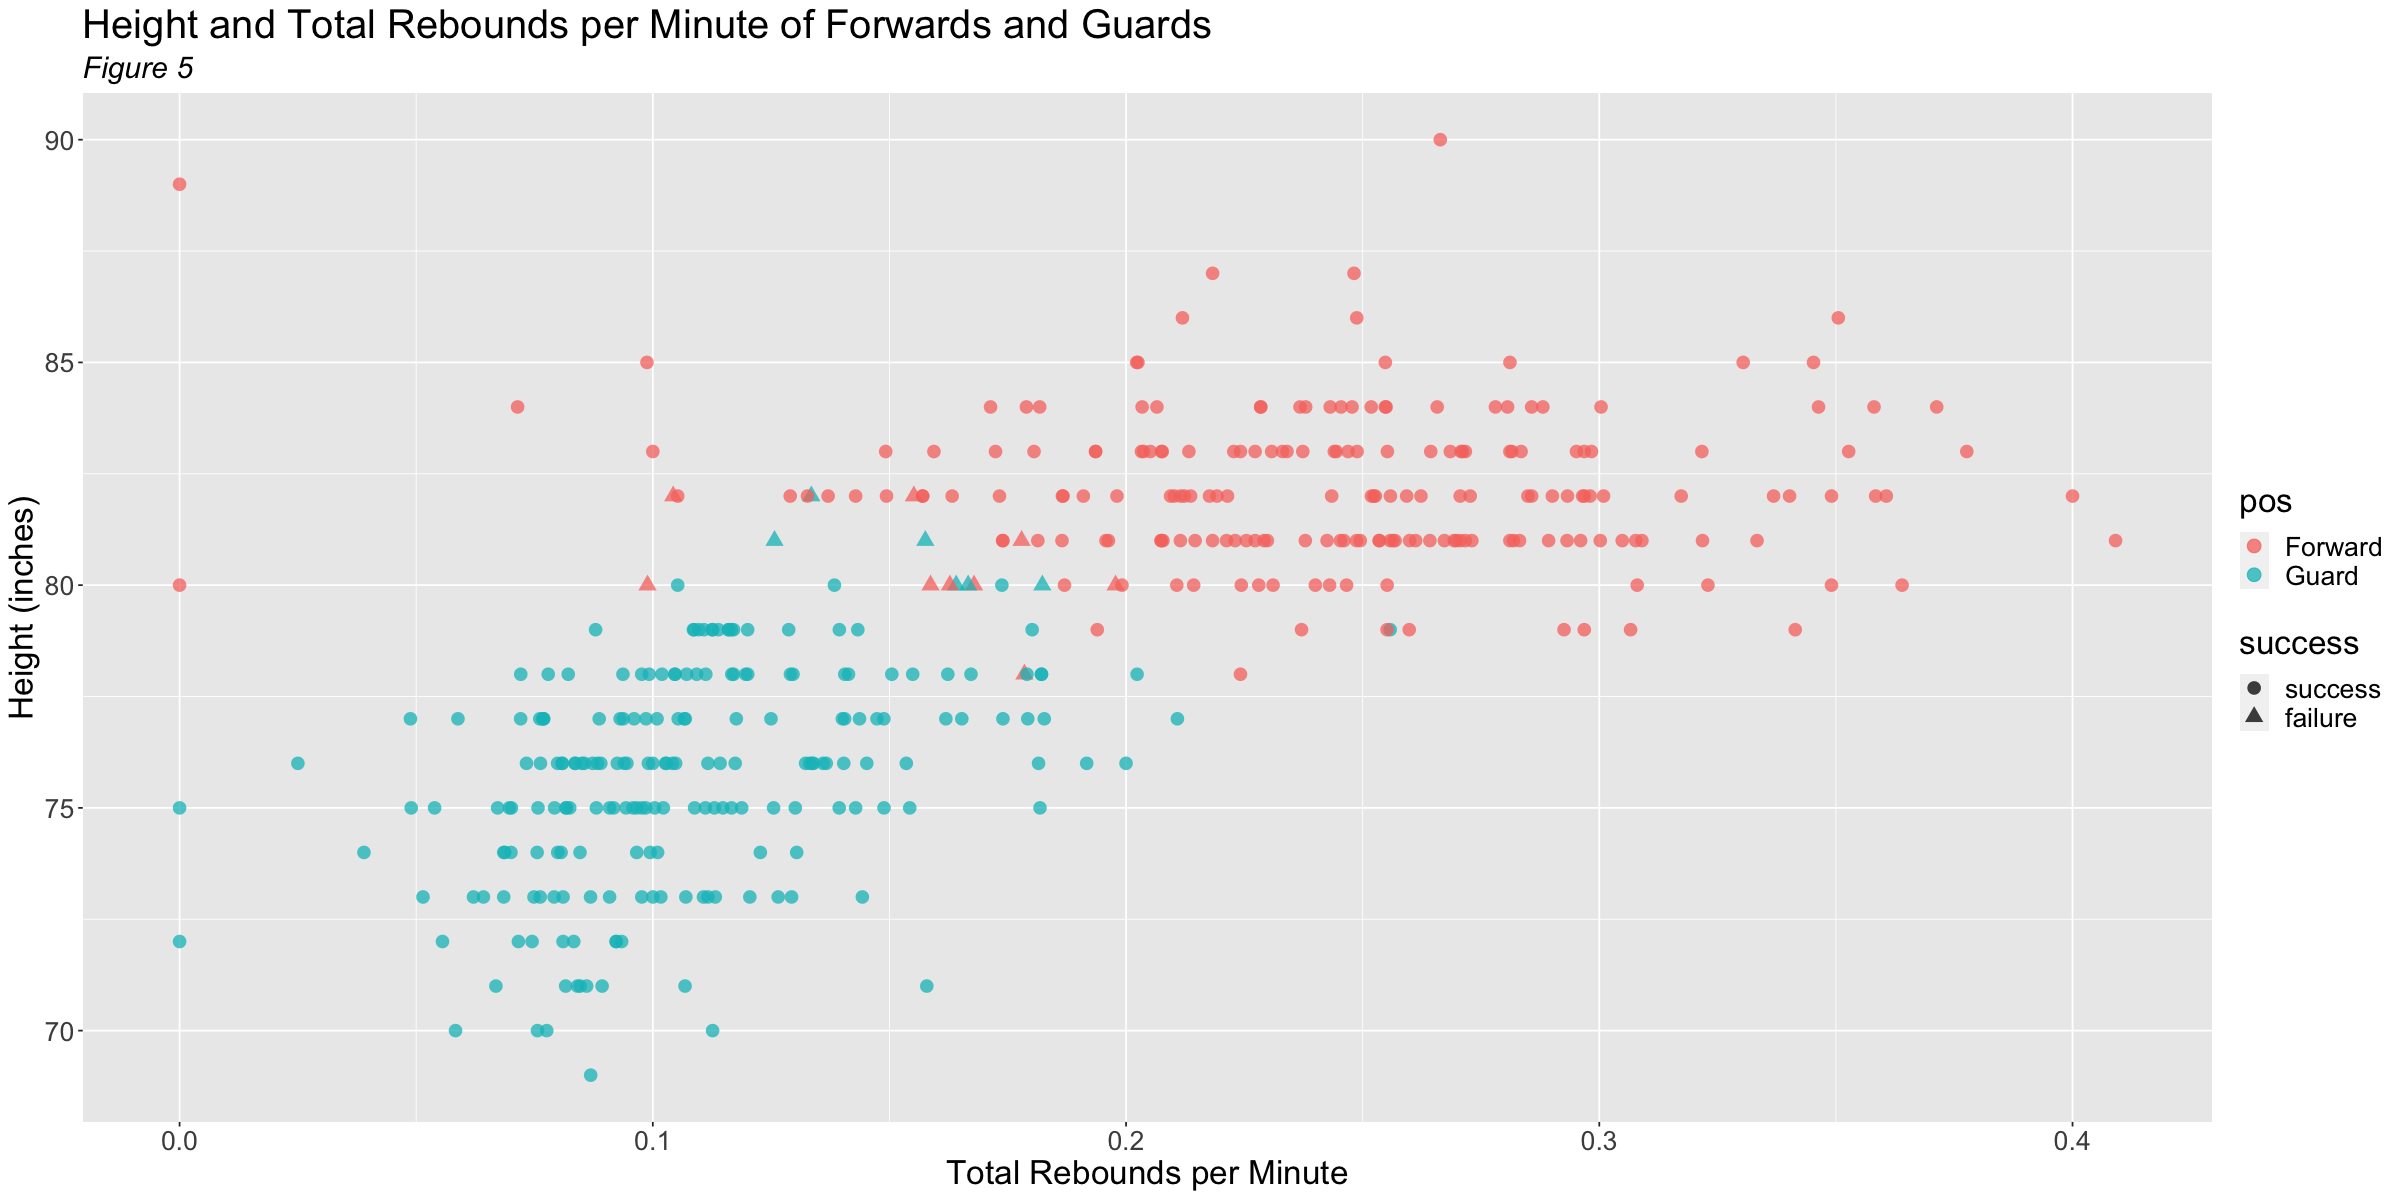

In [40]:
options(repr.plot.width = 20, repr.plot.height = 10)

predictions |>
    filter(TRB_per_MP < .5)  |>
    mutate(success = as_factor(ifelse(.pred_class == pos, "success", "failure"))) |> 
    ggplot(aes(x = TRB_per_MP, y = height, color = pos)) +
    geom_point(aes(shape = success), size = 3.5, alpha = 0.75) +
    theme(text = element_text(size = 20), 
          plot.subtitle = element_text(size=18, face="italic", color="black")) + 
    labs(title = "Height and Total Rebounds per Minute of Forwards and Guards",
         x = "Total Rebounds per Minute", 
         y = "Height (inches)", 
         subtitle = "Figure 5")

Above we plot the Height and Total Rebounds per Minute of the players in the testing data. We filtered out 2 outliers that made the graph difficult to read. Successful predictions are circles, and unsuccessful predictions are triangles. We have established the relationship between a player's Height and their Total Rebounds per Minute, as well as associated taller players as forwards. 

# Discussion

To summarize: we built a classification model that is able to predict whether a player is a Guard or Forward using their physical attributes and their gameplay statistics in the game of Basketball, with an accuracy 96.44% on test data, which means it has a high accuracy. Our findings are mostly in line with our expectations: there are some clear roles that allow us to classify players easily, but the difference between some positions is very slight which makes distinguishing between these positions (e.g., Center and Power Forward) more difficult.

There is a caveat to our accuracy number, which is that we simplified our problem by grouping the Shooting Guard and Point Guard into one class and the Center and Power Forward into another class and excluding Small Forwards from our data. In an earlier version of our work we built a model that differentiated between all 5 positions, but was much less accurate (~ 0.63 on training data). We realized the problem could be in trying to differentiate between two very similar positions. For example, a Center's physical and statistical attributes are very similar to a Power Forward's, and this is also the case for a Shooting Guard and Point Guard (see Figure 2). Taking this into consideration, we built a new model with a much higher accuracy (~ 0.90 on training data.) that only differentiated between two groups: Guards and Forwards (including Power Forward). This large jump in accuracy indicates that it is difficult to predict the exact position of a player given past gameplay statistics and physical attributes, but whether the player is a Guard (including Point Guard, Shooting Guard) or Forward (including Center, Small Forward, Power Forward) is more predictable. This is because Guards and Forwards have little overlap in gameplay statistics and physical attributes (see Figure 2.)

Later, we chose to remove Small Forwards from our analysis because, as shown in Figure 3, the Small Forward distribution for predictor variable is situated between the Guard and other Forwards distributions, which may make it difficult to distinguish. 

**Applications**

Our classification model could be used by basketball teams to find the most suitable position for prospective college players they're looking to draft.

**Further Questions**

There are many opportunities for future investigations in this area. Notably, how much of an effect does each predictor variable have on determining a player's position? Are there more advanced classification techniques that would allow for the creation of a reasonably accurate model that differentiates between all 5 positions instead of just the 2 categories presented here?

# Sources

Dezman, B., Trninić, S., & Dizdar, D. (2001). Expert model of decision-making system for efficient orientation of basketball players to positions and roles in the game--empirical verification. Collegium Antropologicum, 25(1), 141-152.

Ferioli, D., Rampinini, E., Bosio, A., La Torre, A., Azzolini, M., & Coutts, A. J. (2018). The physical profile of adult male basketball players: Differences between competitive levels and playing positions. Journal of Sports Sciences, 36(22), 2567-2574. https://doi.org/10.1080/02640414.2018.1469241